<a href="https://colab.research.google.com/github/haneenbadr/BrainTumor-CT-scan-with-ResNet50/blob/main/Brain_tumor_CT_SCAN_with_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle (1).json to kaggle (1).json
User uploaded file "kaggle (1).json" with length 66 bytes
mv: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d murtozalikhon/brain-tumor-multimodal-image-ct-and-mri

Dataset URL: https://www.kaggle.com/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri
License(s): CC-BY-NC-SA-4.0
 97% 349M/361M [00:03<00:00, 160MB/s]
100% 361M/361M [00:03<00:00, 118MB/s]


In [3]:
from zipfile import ZipFile
file_name = "/content/brain-tumor-multimodal-image-ct-and-mri.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
import os
import shutil
import random


dataset_path = "/content/Dataset/Brain Tumor CT scan Images"
classes = ['Healthy', 'Tumor']


train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')


for dir_path in [train_dir, val_dir, test_dir]:
    for cls in classes:
        os.makedirs(os.path.join(dir_path, cls), exist_ok=True)


for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = os.listdir(class_path)
    random.shuffle(images)

    train_split = int(0.7 * len(images))
    val_split = int(0.9 * len(images))

    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]

    for img in train_images:
        shutil.move(os.path.join(class_path, img), os.path.join(train_dir, cls, img))

    for img in val_images:
        shutil.move(os.path.join(class_path, img), os.path.join(val_dir, cls, img))

    for img in test_images:
        shutil.move(os.path.join(class_path, img), os.path.join(test_dir, cls, img))

In [6]:
train_data =ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(dataset_path, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(dataset_path, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 3232 images belonging to 2 classes.
Found 924 images belonging to 2 classes.
Found 462 images belonging to 2 classes.


In [8]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)


model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True
# )


history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    #callbacks=[early_stopping]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 40s 247ms/step - accuracy: 0.5526 - loss: 0.7272 - val_accuracy: 0.7251 - val_loss: 0.5941
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 26s 167ms/step - accuracy: 0.7042 - loss: 0.5901 - val_accuracy: 0.7565 - val_loss: 0.5508
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 18s 174ms/step - accuracy: 0.7414 - loss: 0.5448 - val_accuracy: 0.7652 - val_loss: 0.5265
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.7440 - loss: 0.5294 - val_accuracy: 0.7781 - val_loss: 0.5031
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.7838 - loss: 0.5016 - val_accuracy: 0.7900 - val_loss: 0.4848
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 0.7915 - loss: 0.4804 - val_accuracy: 0.7955 - val_loss: 0.4700
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 0.8045 - loss: 0.4635 - val_accuracy: 0.7976 - val_loss: 0.4580
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.7999 - loss: 0.458

In [9]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 365ms/step - accuracy: 0.9049 - loss: 0.2585
Test Accuracy: 0.87


In [10]:
y_true = test_data.classes
y_pred = (model.predict(test_data) > 0.5).astype("int32")
print(classification_report(y_true, y_pred, target_names=list(test_data.class_indices.keys())))

15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step
              precision    recall  f1-score   support

     Healthy       0.83      0.93      0.88       230
       Tumor       0.92      0.81      0.86       232

    accuracy                           0.87       462
   macro avg       0.87      0.87      0.87       462
weighted avg       0.87      0.87      0.87       462



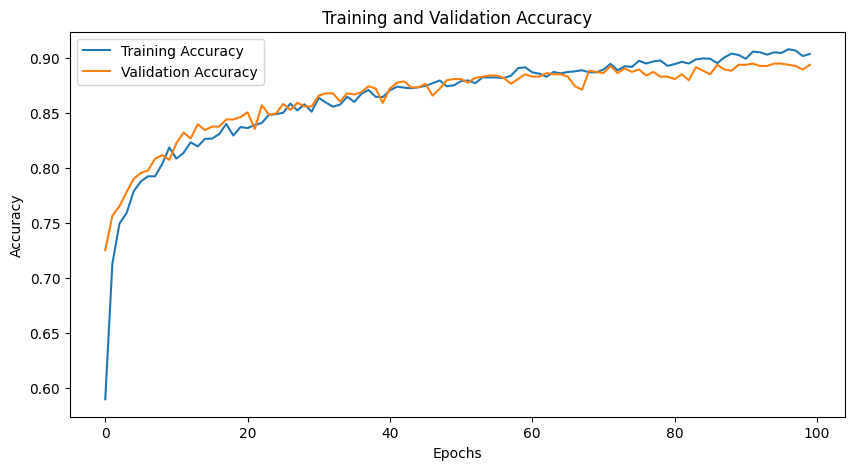

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



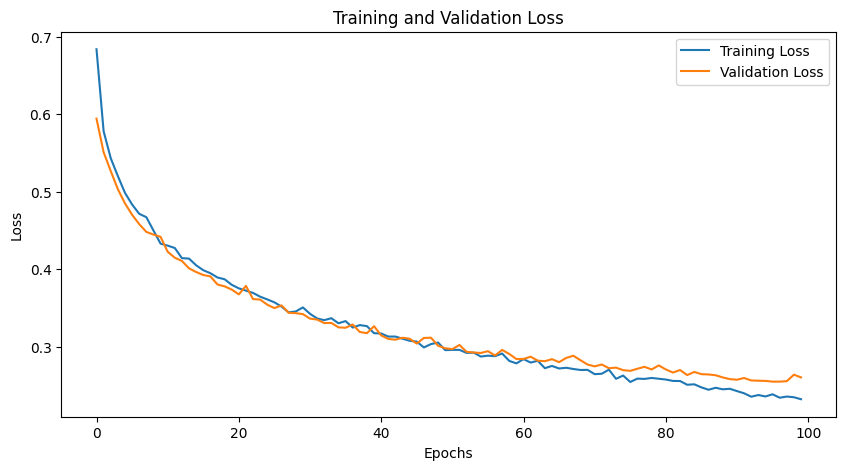

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

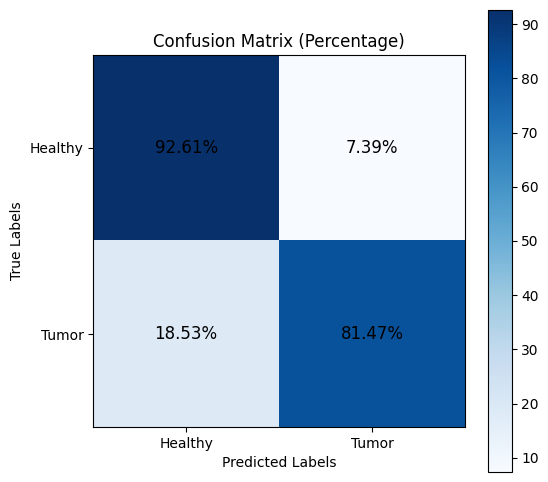

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


cm = confusion_matrix(y_true, y_pred)


cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 6))
plt.imshow(cm_percentage, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix (Percentage)')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0, 1], test_data.class_indices.keys())
plt.yticks([0, 1], test_data.class_indices.keys())


for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f'{cm_percentage[i, j]:.2f}%',
                 ha='center', va='center', color='black', fontsize=12)

plt.show()